In [43]:
import pandas as pd
from tensorflow.python.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.python.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.python.layers.convolutional import Conv1D
from tensorflow.python.layers.core import Flatten
from tensorflow.python.layers.pooling import MaxPooling1D
from tqdm import tqdm
from numpy import array

In [45]:
DATASET_PATH = \
    r"https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
DATE_COLUMN = "Month"
X_COLUMN = "Passengers"

# parse_dates : parses dates from string to DatetimeIndex
# index_col : set specified column as dataset index
df = pd.read_csv(DATASET_PATH, parse_dates=[DATE_COLUMN], index_col=DATE_COLUMN)
df.head(10)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [46]:
# NOTE : You dont need the dates column here
x_train = df[X_COLUMN].values
x_test = df[X_COLUMN].values

x_test

array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
       405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467,
       404, 347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505, 404,
       359, 310, 337, 360, 342, 406, 396, 420, 472, 548, 559, 463, 407,
       362, 405, 417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390,
       432])

In [47]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in tqdm(range(len(sequence))):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


n_steps = 4
n_features = 1
# dividing train sequence into input/output samples
x_train, y_train = split_sequence(x_train, n_steps=n_steps)
# dividing test sequence into input/output samples
x_test, y_test = split_sequence(x_test, n_steps=n_steps)

for i in range(len(x_train)):
    print(x_train[i], y_train[i])

 97%|█████████▋| 140/144 [00:00<00:00, 51127.78it/s]

[112 118 132 129] 121
[118 132 129 121] 135
[132 129 121 135] 148
[129 121 135 148] 148
[121 135 148 148] 136
[135 148 148 136] 119
[148 148 136 119] 104
[148 136 119 104] 118
[136 119 104 118] 115
[119 104 118 115] 126
[104 118 115 126] 141
[118 115 126 141] 135
[115 126 141 135] 125
[126 141 135 125] 149
[141 135 125 149] 170
[135 125 149 170] 170
[125 149 170 170] 158
[149 170 170 158] 133
[170 170 158 133] 114
[170 158 133 114] 140
[158 133 114 140] 145
[133 114 140 145] 150
[114 140 145 150] 178
[140 145 150 178] 163
[145 150 178 163] 172
[150 178 163 172] 178
[178 163 172 178] 199
[163 172 178 199] 199
[172 178 199 199] 184
[178 199 199 184] 162
[199 199 184 162] 146
[199 184 162 146] 166
[184 162 146 166] 171
[162 146 166 171] 180
[146 166 171 180] 193
[166 171 180 193] 181
[171 180 193 181] 183
[180 193 181 183] 218
[193 181 183 218] 230
[181 183 218 230] 242
[183 218 230 242] 209
[218 230 242 209] 191
[230 242 209 191] 172
[242 209 191 172] 194
[209 191 172 194] 196
[191 172 1

In [48]:
n_seq = 2
n_steps = 2
# reshape from [samples, timesteps] into [samples,subsequences,timesteps, features]
# This is because input is taken by CNN first then passed to LSTM
x_train = x_train.reshape((x_train.shape[0], n_seq, n_steps, n_features))
x_test = x_test.reshape((x_test.shape[0], n_seq, n_steps, n_features))

x_train[:5]

array([[[[112],
         [118]],

        [[132],
         [129]]],


       [[[118],
         [132]],

        [[129],
         [121]]],


       [[[132],
         [129]],

        [[121],
         [135]]],


       [[[129],
         [121]],

        [[135],
         [148]]],


       [[[121],
         [135]],

        [[148],
         [148]]]])

In [51]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2,strides=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, None, 2, 64)       128       
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 64)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 23,179
Trainable params: 23,179
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:1358: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


In [52]:
# fit model
model.fit(x_train, y_train,epochs=200,validation_data=(x_test,y_test))

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:1358: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


5/5 [==============================] - 32s 126ms/step - loss: 81426.5859 - val_loss: 74314.4297
Epoch 2/200
5/5 [==============================] - 0s 31ms/step - loss: 72113.0938 - val_loss: 68450.7266
Epoch 3/200
5/5 [==============================] - 0s 29ms/step - loss: 66294.0000 - val_loss: 61909.7422
Epoch 4/200
5/5 [==============================] - 0s 25ms/step - loss: 59445.0625 - val_loss: 54824.3633
Epoch 5/200
5/5 [==============================] - 0s 26ms/step - loss: 51336.6758 - val_loss: 43962.5195
Epoch 6/200
5/5 [==============================] - 0s 25ms/step - loss: 40899.4648 - val_loss: 35109.2812
Epoch 7/200
5/5 [==============================] - 0s 27ms/step - loss: 31485.6211 - val_loss: 20788.3066
Epoch 8/200
5/5 [==============================] - 0s 27ms/step - loss: 16164.8086 - val_loss: 11313.9570
Epoch 9/200
5/5 [==============================] - 0s 30ms/step - loss: 9525.8848 - val_loss: 6467.6914
Epoch 10/200
5/5 [==============================] - 0s 30m

In [54]:
x_input = array([606,508,461,390])
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:1358: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


[[431.0091]]


In [55]:
# Testing on x_test
predictions = model.predict(x_test)
# bringing to similar shape
predictions = predictions.reshape(y_test.shape)

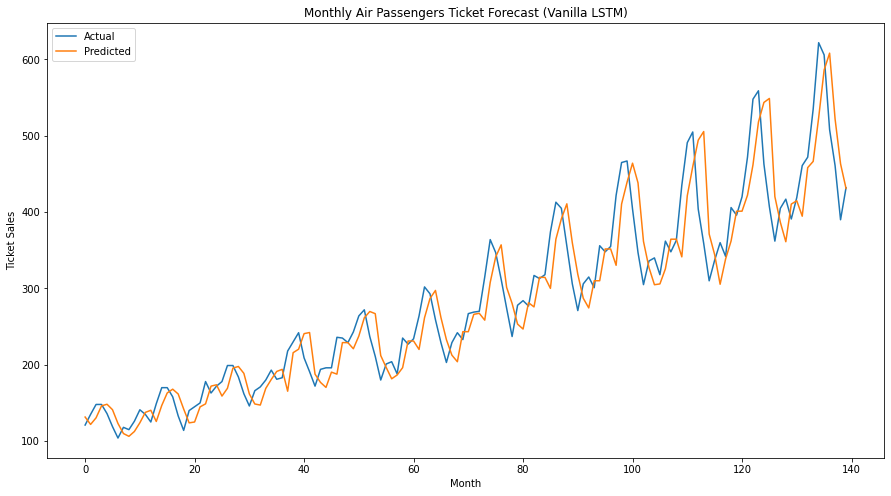

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.plot(y_test,label="Actual")
plt.plot(predictions,label="Predicted")
plt.legend()
plt.title("Monthly Air Passengers Ticket Forecast (Vanilla LSTM)")
plt.xlabel("Month")
plt.ylabel("Ticket Sales")
plt.show()